<a href="https://colab.research.google.com/github/Ashu-00/LLM-Implementations/blob/main/Attention_is_All_you_Need_(Paper_Implementation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

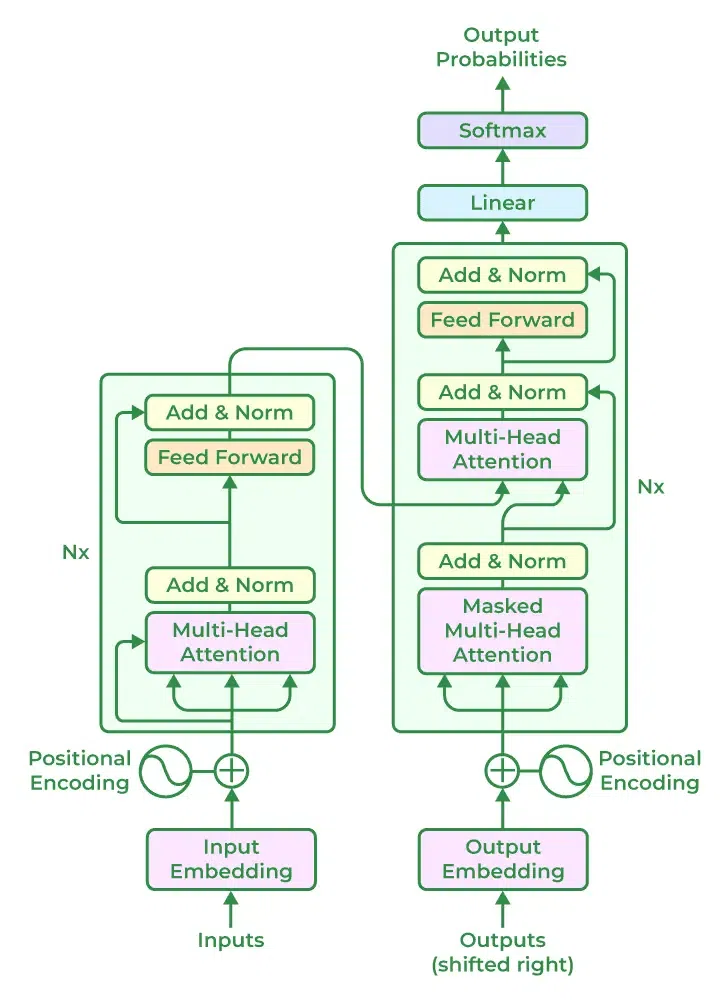

**SELF ATTENTION AND TRANSFORMER BLOCK**

*SELF ATTENTION BLOCK*


---


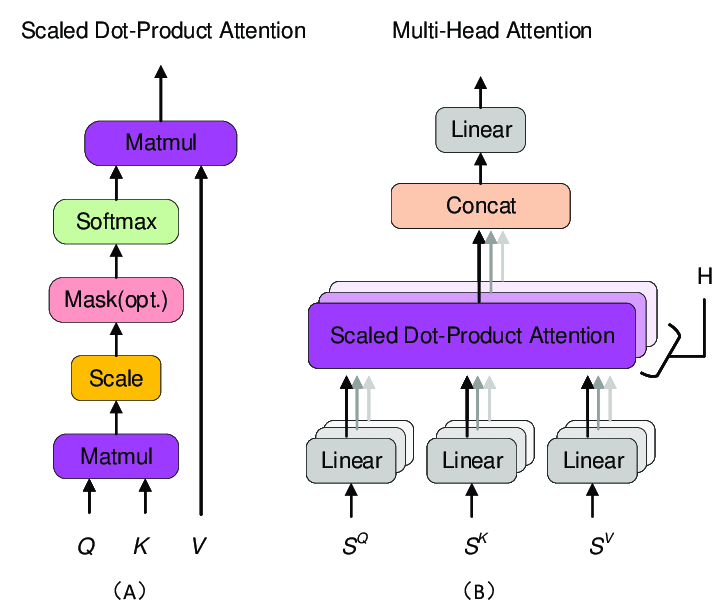

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size,heads):
    super().__init__()
    self.embed_size= embed_size
    self.heads=heads
    assert embed_size %heads==0, "invalid(not divisible) embed size"

    self.head_dim=embed_size//heads

    self.values=nn.Linear(self.head_dim,self.head_dim,bias=False)
    self.keys=nn.Linear(self.head_dim,self.head_dim,bias=False)
    self.query=nn.Linear(self.head_dim,self.head_dim,bias=False)

    self.fc_out=nn.Linear(self.heads*self.head_dim,embed_size)


  def forward(self,query,keys,values,mask=None):

    N=keys.shape[0]

    qlen,klen,vlen=query.shape[1],keys.shape[1],values.shape[1]

    values=self.values(values)
    keys=self.keys(keys)
    query=self.query(query)

    keys=keys.reshape(N,klen,self.heads,self.head_dim)
    query=query.reshape(N,qlen,self.heads,self.head_dim)
    values=values.reshape(N,vlen,self.heads,self.head_dim)

    #the output is Q.K(T).
    #Q dim-> N,q,h,hdim
    #K dim-> N,k,h,hdim
    #op/energy dim-> N,h,q,k
    energy=torch.einsum("nqhd,nkhd->nhqd",[query,keys])

    if mask:
      energy=energy.masked_fill(mask==0,float(-1e20))
      #masking the 0 values of mask to -inf

    #softmax over key dim
    attention=F.softmax((energy/(self.embed_size**(1/2))),dim=3)

    #attention*value
    #att-> N,h,q,k
    #val-> N,k,h,d (v=k)
    #out-> N,q,h,d
    #flatten to N,q,h*d
    out=torch.einsum("nhqk,nkhd->nqhd",[attention,values]).reshape(N,qlen,self.heads*self.head_dim)

    return self.fc_out(out)





*TRANSFORMER BLOCK*

---


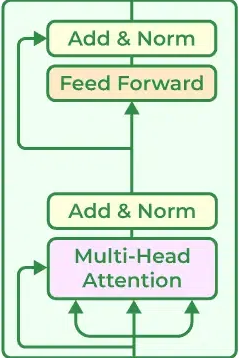

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self,embed_size,heads,fexp,dropout):
    super().__init__()
    self.attention=SelfAttention(embed_size,heads)
    self.norm1=nn.LayerNorm(embed_size)
    self.norm2=nn.LayerNorm(embed_size)

    self.feed_forward=nn.Sequential(
        nn.Linear(embed_size,fexp*embed_size),
        nn.ReLU(),
        nn.Linear(fexp*embed_size,embed_size)
    )

    self.drop=nn.Dropout(dropout)

  def forward(self,q,k,v,mask):
    attention=self.attention(q,k,v,mask)

    x=self.drop(self.norm1(attention+q))

    ff=self.feed_forward(x)

    return self.drop(self.norm2(ff+x))



**ENCODER**


---

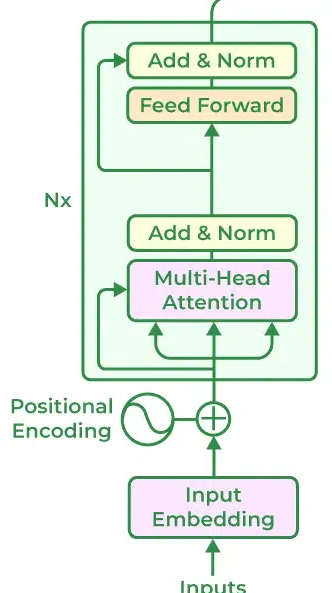

In [ ]:
class Encoder(nn.Module):
  def __init__(
      self,
      vocab_size,
      embed_size,
      heads,
      num_layers,
      fexp,
      dropout,
      device,
      maxlength,
  ):
    super().__init__()
    self.embed_size=embed_size
    self.device=device

    self.ipemb=nn.Embedding(vocab_size,embed_size)
    self.pemb=nn.Embedding(maxlength,embed_size)
    self.drop=nn.Dropout(dropout)

    self.layers=nn.ModuleList(
        [
            TransformerBlock(embed_size,heads,fexp,dropout,device)
            for _ in range(num_layers)
        ]
    )

  def forward(self,x,mask):
    N,seq_len=x.shape

    #Giving position values to words
    positions=torch.arange(0,seq_len).expand(N,seq_len).to(self.device)

    #Addition of position and input embeddings
    out=self.ipemb(x)+self.pemb(positions)
    out=self.drop(out)

    #Tranformer Block * num_layers
    for layer in self.layers:
      out=layer(out,out,out,mask)

    return out


**DECODER**


*DECODER BLOCK*


---

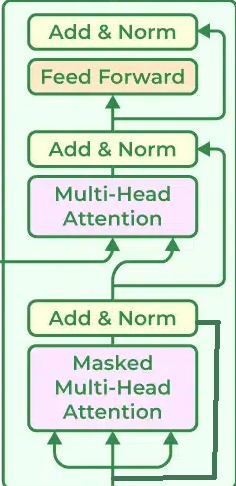

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self,embed_Size,heads,fexp,dropout,device):
    super().__init__()
    self.mask_att=SelfAttention(embed_Size,heads)
    self.norm1=nn.LayerNorm(embed_Size)
    self.TransBlck=TransformerBlock(embed_Size,heads,fexp,dropout)
    self.drop=nn.Dropout(dropout)

  def forward(self,x,key,value,srcmask,trgtmask):
    attention=self.mask_att(x,x,x,trgtmask)
    x=self.drop(self.norm1(x+attention))
    out=self.TransBlck(x,key,value,srcmask)

    return out

*DECODER*


---

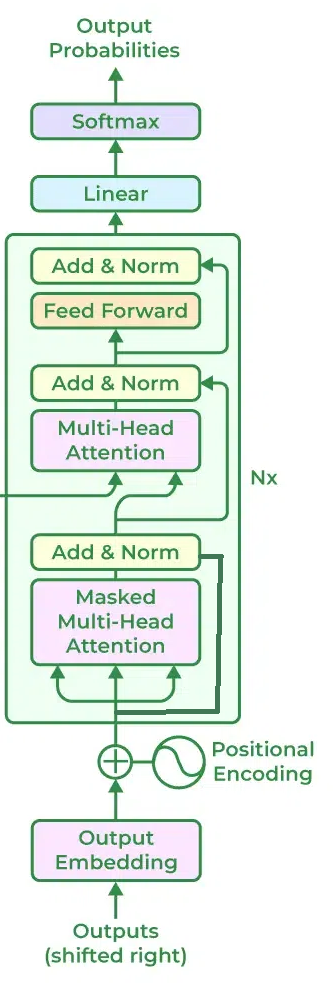

In [ ]:
class Decoder(nn.Module):
  def __init__(
      self,
      vocab_size,
      embed_size,
      heads,
      num_layers,
      fexp,
      dropout,
      device,
      maxlength,
  ):
    super().__init__()
    self.device=device

    self.opemb=nn.Embedding(vocab_size,embed_size)
    self.opposemb=nn.Embedding(maxlength,embed_size)
    self.drop=nn.Dropout(dropout)

    self.layers=nn.ModuleList(
        [
            DecoderBlock(embed_size,heads,fexp,dropout,device)
            for _ in range(num_layers)
        ]
    )

    self.oplinear=nn.Linear(embed_size,vocab_size)

  def forward(self,x,encout,srcmask,trgtmask):

    N,seq_len=x.shape

    #Giving position values to words
    positions=torch.arange(0,seq_len).expand(N,seq_len).to(self.device)

    out=self.ipemb(x)+self.pemb(positions)
    out=self.drop(out)

    #Tranformer Block * num_layers
    for layer in self.layers:
      out=layer(out,encout,encout,srcmask,trgtmask)

    return self.oplinear(out)


**TRANSFORMER**


---



In [ ]:
class Transformer(nn.Module):
  def __init__(
      self,
      src_vocab_size,
      trgt_vocab_size,
      src_pad_idx,
      trgt_pad_idx,
      embed_size=256,
      num_layers=6,
      heads=8,
      fexp=4,
      dropout=0,
      device="cpu",
      maxlength=100,
  ):
    super().__init__()

    self.encoder= Encoder(
      self,
      src_vocab_size,
      embed_size,
      heads,
      num_layers,
      fexp,
      dropout,
      device,
      maxlength,
    )

    self.decoder= Decoder(
      self,
      trgt_vocab_size,
      embed_size,
      heads,
      num_layers,
      fexp,
      dropout,
      device,
      maxlength,
    )

    self.src_pad_idx=src_pad_idx
    self.trgt_pad_idx=trgt_pad_idx

    self.device=device

  def make_src_mask(self,src):
    return (src!=self.src_pad_idx).unsqueeze(1,2).to(self.device)

  def make_trgt_mask(self,trgt):
    N,trgt_len=trgt.shape
    return torch.tril(torch.ones((trgt_len,trgt_len))).expand(N,1,trgt_len,trgt_len).to(self.device)

  def forward(self,src,trgt):
    smask=self.make_src_mask(src)
    tmask=self.make_trgt_mask(trgt)
    encout=self.encoder(src,smask)
    out=self.decoder(trgt,encout,smask,tmask)
    return out
